In [45]:
import pandas as pd
import ast

In [46]:
df = pd.read_parquet("../data/webquestions/webquestions-frob.parquet")
df["answers"] = df["answers"].apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else s)
print(df.columns)
df.groupby("labels")["frob"].describe()


Index(['question', 'answers', 'labels', 'predictions', 'frob'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
far-ood,853.0,0.559773,0.063360,0.220334,0.532577,0.574985,0.602751,0.669850
in,271.0,0.510580,0.089277,0.144384,0.455998,0.529610,0.578275,0.662562
near-ood,299.0,0.516282,0.088281,0.185624,0.463072,0.539473,0.583913,0.660323


<Figure size 600x400 with 0 Axes>

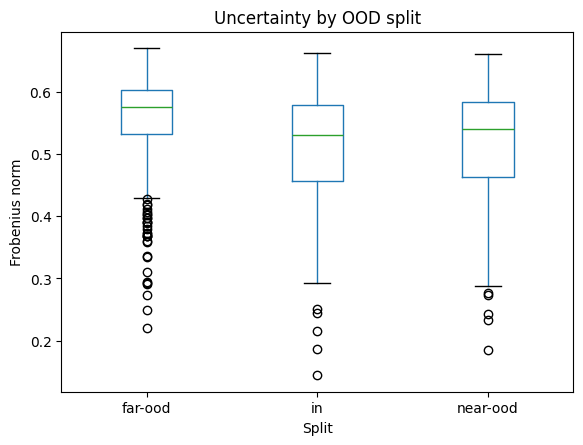

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df.boxplot(column="frob", by="labels", grid=False)
plt.title("Uncertainty by OOD split")
plt.suptitle("")
plt.xlabel("Split")
plt.ylabel("Frobenius norm")
plt.show()


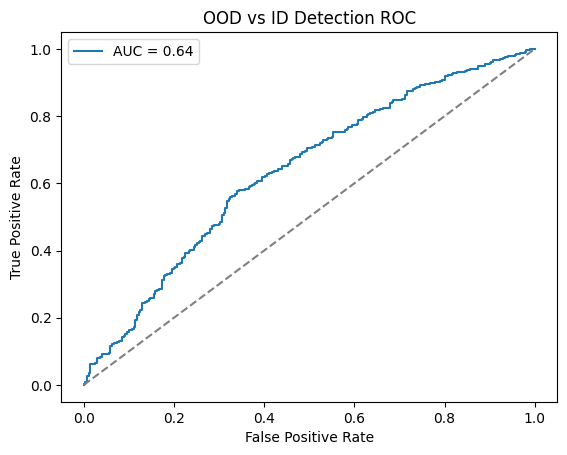

In [ ]:
from sklearn.metrics import roc_curve, auc

y_true  = (df["labels"] != "in").astype(int)
y_score = df["frob"].to_numpy()

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc     = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOD vs ID Detection ROC")
plt.legend()
plt.show()


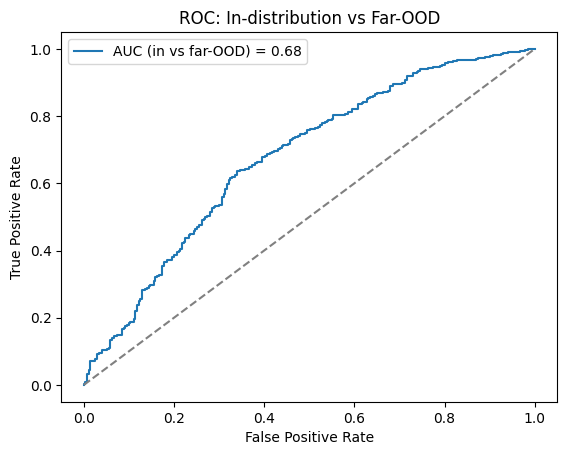

In [52]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1) select only in‐distribution vs far‐OOD rows
mask = df["labels"].isin(["in", "far-ood"])

# 2) build your binary ground‐truth: far-ood → 1, in → 0
y_true  = (df.loc[mask, "labels"] == "far-ood").astype(int)

# 3) pull out the corresponding uncertainty scores
y_score = df.loc[mask, "frob"].to_numpy()

# 4) compute ROC + AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc     = auc(fpr, tpr)

# 5) plot
plt.plot(fpr, tpr, label=f"AUC (in vs far-OOD) = {roc_auc:.2f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: In-distribution vs Far-OOD")
plt.legend()
plt.show()


In [49]:
from collections import Counter


def most_frequent(lst: list[str]) -> str:
    filtered = [s for s in lst if s]
    return Counter(filtered).most_common(1)[0][0]


df["hard_pred"] = df["predictions"].apply(most_frequent)

print(df[df["labels"] == "in"].head())

                                             question  \
6                  what else did ben franklin invent?   
11  where is the fukushima daiichi nuclear plant l...   
12  who is the minority leader of the house of rep...   
22              what is the australian dollar called?   
23                           what timezone is sweden?   

                                              answers labels  \
6   [Lightning rod, Franklin stove, Bifocals, Glas...     in   
11                                     [Japan, Okuma]     in   
12                                     [Nancy Pelosi]     in   
22                                [Australian dollar]     in   
23                            [Central European Time]     in   

                                          predictions      frob  \
6   [GoldInPhGold, Hein-de-Von, Bifocillism, Bifib...  0.588394   
11  [Okanaya, Japan, Tokyo, Okazaki, Japan, Okazak...  0.432301   
12  [Clutor Méséx, Nancy Pelosi, Solovie Ross, Nan...  0.606415   
22  

In [ ]:
def is_exact_match(pred: str, golds: list[str]) -> bool:
    return pred in golds

df["correct"] = df.apply(
    lambda r: is_exact_match(r["hard_pred"], r["answers"]),
    axis=1,
)

# per split EM score
print(100 * df.groupby("labels")["correct"].sum() / df.groupby("labels")["correct"].count())
print(df.groupby("labels")["correct"].sum())
print(df.groupby("labels")["correct"].count())

# overall EM score
print(100 * df["correct"].sum() / df["correct"].count())
print(df["correct"].sum())
print(df["correct"].count())

labels
far-ood      0.586166
in          33.579336
near-ood    17.725753
Name: correct, dtype: float64
labels
far-ood      5
in          91
near-ood    53
Name: correct, dtype: int64
labels
far-ood     853
in          271
near-ood    299
Name: correct, dtype: int64
10.470836261419537
149
1423


In [51]:
df[(df["correct"]) & (df["labels"] == "far-ood")]

,question,answers,labels,predictions,frob,hard_pred,correct
265,how deep is lake merritt oakland?,[Oakland],far-ood,"[Lake Merritt, Oakland, Oakland, How deep is l...",0.483534,Oakland,True
477,when does school start for the university of o...,[University of Oregon],far-ood,"[Oregon state, Oregon Institute of Technology,...",0.507418,University of Oregon,True
673,what county is san diego ca?,[San Diego County],far-ood,"[Guatemala, Central San Diego County, San Dieg...",0.367694,San Diego County,True
787,what county is san diego in?,[San Diego County],far-ood,"[Los Angeles County, California, San Diego Cou...",0.358204,San Diego County,True
1287,what currency does singapore use?,[Singapore dollar],far-ood,"[Singpore franc, Miamic, Singapore Singaporeen...",0.373442,Singapore dollar,True
